This jupyter notebook is release under GPL3 licence and is part of a [Github repository](https://github.com/tgrippa/Demo_Docker_GRASS_R) with instructions and complementary files. 

Author: [Grippa Taïs](https://tgrippa.github.io/).

Other example of Jupyter notebook using GRASS GIS can be found [HERE](https://grasswiki.osgeo.org/wiki/GRASS_GIS_Jupyter_notebooks).

# Configuration of the working environment

## Import libraries and define GRASS python path

**Importing Python libraries and modules**

In [1]:
# Import base Python libraries 
import os
import sys
import subprocess
import shutil
# Import Pandas library
import pandas as pd
# Import Numpy library
import numpy as np
# Import SciPy library
import scipy as scipy
# Import IPython packages for display in the notebook
from IPython.display import Image

**Add folder with SCR provided belong to this notebook**

In [2]:
# Add local module to the path
src = os.path.abspath('../SRC')
if src not in sys.path:
    sys.path.append(src)

**Setup environment variables**

Please edit the file in `../SRC/config.py`, containing the configuration parameters, according to your own computer setup. The following cell is used to run this file.



In [3]:
run ../SRC/config_linux.py

In [4]:
# Import functions that setup the environmental variables
import environ_variables_linux as envi

In [5]:
# Set environmental variables
envi.setup_environmental_variables() 
# Display current environment variables of your computer
envi.print_environmental_variables()

PATH	= /.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/lib/grass78/bin:/usr/lib/grass78/script:/usr/lib/grass78/lib 	
HOSTNAME	= 0b9154c70dd4 	
DISPLAY	= unix:1 	
LANG	= C.UTF-8 	
LC_ALL	= C.UTF-8 	
JUPYTER_ENABLE_LAB	= yes 	
TINI_VERSION	= v0.6.0 	
HOME	= /home/demo_user 	
JPY_PARENT_PID	= 7 	
TERM	= xterm-color 	
CLICOLOR	= 1 	
PAGER	= cat 	
GIT_PAGER	= cat 	
MPLBACKEND	= module://ipykernel.pylab.backend_inline 	
PYTHONPATH	= :/usr/lib/grass78/etc/python:/usr/lib/grass78/etc/python/grass:/usr/lib/grass78/etc/python/grass/script 	
LD_LIBRARY_PATH	= :/usr/lib/grass78/lib 	
GISBASE	= /usr/lib/grass78 	
PYTHONLIB	= /usr/bin/python3 	
GIS_LOCK	= $$ 	
GISRC	= /home/demo_user/.grass7/rc 	


**Importing GRASS GIS libraries and modules**

In [6]:
#Import libraries needed to launch GRASS GIS in the Jupyter Notebook
import grass.script.setup as gsetup
#Import libraries needed to call GRASS using Python
import grass.script as gscript

**Importing other functions**

In [7]:
# Import function that checks existence of GRASS GIS database folder and creates it if needed
from grass_database import launch_mapset
# Import function that checks and creates folder
from mkdir import check_create_dir
# Import function that checks if GRASS GIS add-on is installed and install it if needed
from gextension import check_install_addon

**Create output directory if not exists**

In [8]:
#Check and create output data directory if needed
outputdir = '/home/demo_user/output_container/OBIA'
check_create_dir(outputdir)

The folder '/home/demo_user/output_container/OBIA' already exists


**-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-**

## Setup GRASS GIS session and specific environment variables

In [9]:
# Create a GRASS GIS session.
rcfile = gsetup.init(config_parameters['GISBASE'], "../../GRASSDATA", "nc_spm_08_grass7", "user1")

# We want functions to raise exceptions and see standard output of the modules in the notebook.
gscript.set_raise_on_error(True)
gscript.set_capture_stderr(True)
# Simply overwrite existing maps like we overwrite Python variable values.
os.environ['GRASS_OVERWRITE'] = '1'
# Enable map rendering in a notebook.
os.environ['GRASS_FONT'] = 'sans'
# Set display modules to render into a file (named map.png by default)
os.environ['GRASS_RENDER_IMMEDIATE'] = 'cairo'
os.environ['GRASS_RENDER_FILE_READ'] = 'TRUE'
os.environ['GRASS_LEGEND_FILE'] = 'legend.txt'

## Install required GRASS addons

In [10]:
# Define working mapset 
launch_mapset("PERMANENT")

["Location 'nc_spm_08_grass7' already exist",
 "'PERMANENT' mapset already exists in location 'nc_spm_08_grass7'",
 "You are now working in mapset 'nc_spm_08_grass7/PERMANENT'"]

In [11]:
# Check if add-on is already installed in the computer and install it not yet installed
check_install_addon("r.object.geometry")
check_install_addon("i.segment.stats")
check_install_addon("v.class.mlR")
check_install_addon("i.fusion.hpf")

r.object.geometry have been installed on your computer
i.segment.stats have been installed on your computer
v.class.mlR have been installed on your computer
i.fusion.hpf have been installed on your computer


# List raster layers, display RGB composition

We list the raster maps in the current mapset using [list_string](https://grass.osgeo.org/grass76/manuals/libpython/script.html#script.core.list_strings), using regular expression. Others method exist such as [list_pairs](https://grass.osgeo.org/grass76/manuals/libpython/script.html#script.core.list_pairs) or [list_grouped](https://grass.osgeo.org/grass76/manuals/libpython/script.html#script.core.list_grouped).

These are Landsat 7 bands. For more information on the spectral range of each bands, please refer to the USGS documentation [HERE](https://www.usgs.gov/media/images/landsat-4-5-tm-and-landsat-7-etm-bands-and-their-uses). 

In [12]:
# Print list of landsat bands
landsat_bands = gscript.list_strings("rast", pattern="lsat7", mapset="PERMANENT", flag='r')
for rast in landsat_bands:
    print(rast)

lsat7_2002_10@PERMANENT
lsat7_2002_20@PERMANENT
lsat7_2002_30@PERMANENT
lsat7_2002_40@PERMANENT
lsat7_2002_50@PERMANENT
lsat7_2002_61@PERMANENT
lsat7_2002_62@PERMANENT
lsat7_2002_70@PERMANENT
lsat7_2002_80@PERMANENT


Then, we define our [computational region](https://grasswiki.osgeo.org/wiki/Computational_region) based on the panchromatic image. Also, we save two other regions with specific names that will be used later for display prupose.  

In [13]:
# Define the default computational region to match the extend and spatial resolution of the panchromatic
gscript.run_command('g.region', flags='s', raster='lsat7_2002_80@PERMANENT')

0

In [14]:
# Save a smaller region for zoom display
gscript.run_command('g.region', flags='a', n='220805', s='219650', e='641495', w='639074', save='zoom1')
gscript.run_command('g.region', flags='a', n='220000', s='219900', e='640000', w='639900', save='zoom2')

0

Then, we display a RGB true-color composite.

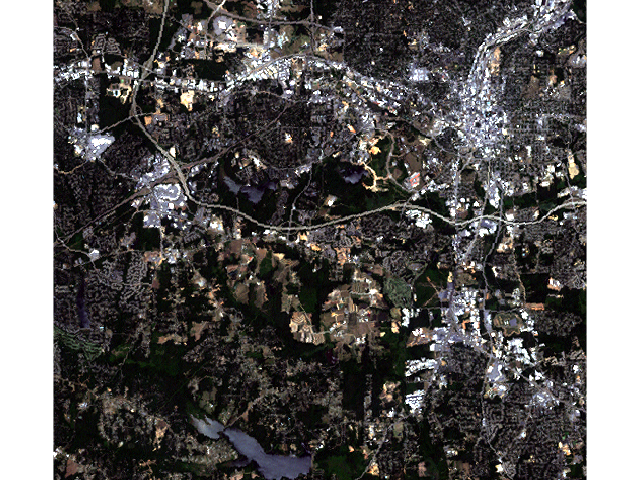

In [15]:
# Define computational region
gscript.run_command('g.region', flags='d')
# Apply histogram equalisation
gscript.run_command('i.colors.enhance', blue='lsat7_2002_10', green='lsat7_2002_20', red='lsat7_2002_30')
# Erase any display instance
gscript.run_command('d.erase')
# Add the buffer layer to the display
gscript.run_command('d.rgb', blue='lsat7_2002_10', green='lsat7_2002_20', red='lsat7_2002_30')
# Display
shutil.copy("map.png",os.path.join(outputdir, "RGB.png"))
Image(filename="map.png")

Alternatively, we can display a RGB false-color near-infrared composite.

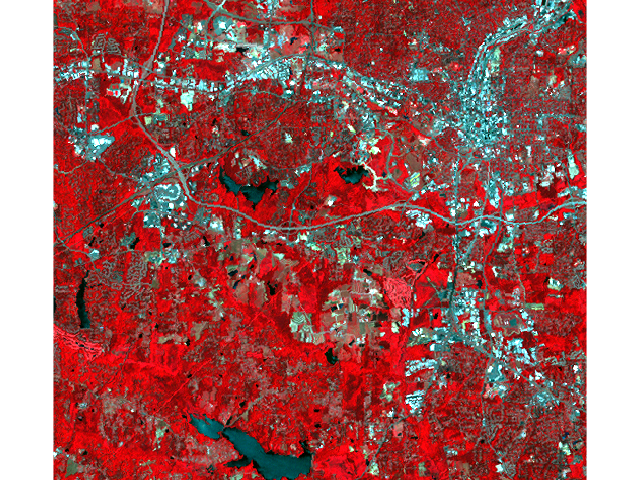

In [16]:
# Define computational region
gscript.run_command('g.region', flags='d')
# Apply histogram equalisation
gscript.run_command('i.colors.enhance', blue='lsat7_2002_20', green='lsat7_2002_30', red='lsat7_2002_40')
# Erase any display instance
gscript.run_command('d.erase')
# Add the buffer layer to the display
gscript.run_command('d.rgb', blue='lsat7_2002_20', green='lsat7_2002_30', red='lsat7_2002_40')
# Display
shutil.copy("map.png",os.path.join(outputdir, "FalseColorNir.png"))
Image(filename="map.png")

# Pansharpening / Fusion of Multispectral and Panchromatic

To improve the spatial resolution of our multispectral images, we perform a pansharpening using [i.fusion.hpf](https://grass.osgeo.org/grass78/manuals/addons/i.fusion.hpf.html) add-on.

In [17]:
# Define working mapset 
launch_mapset("user1")

["Location 'nc_spm_08_grass7' already exist",
 "'user1' mapset already exists in location 'nc_spm_08_grass7'",
 "You are now working in mapset 'nc_spm_08_grass7/user1'"]

In [18]:
# Fusion of Panchromatic and Multispectral bands
gscript.run_command('g.region', flags='d') 
gscript.run_command('i.fusion.hpf', pan='lsat7_2002_80', msx='lsat7_2002_10,lsat7_2002_20,lsat7_2002_30,lsat7_2002_40', suffix='hpf')

0

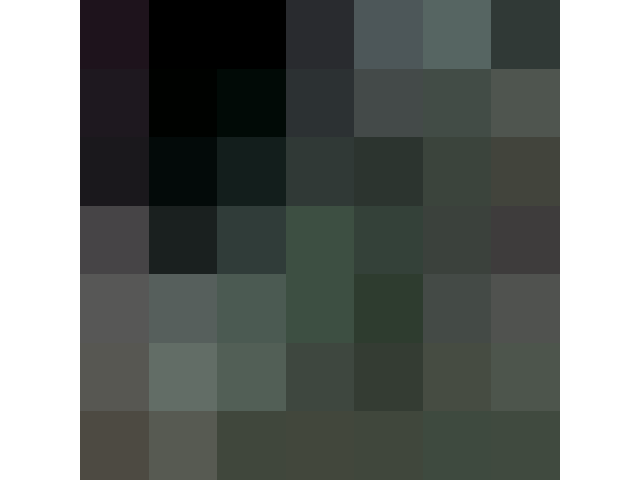

In [19]:
# Apply histogram equalisation
gscript.run_command('g.region', flags='d')
gscript.run_command('i.colors.enhance', blue='lsat7_2002_10hpf', green='lsat7_2002_20hpf', red='lsat7_2002_30hpf')
# Erase any display instance
gscript.run_command('g.region', region='zoom2')
gscript.run_command('d.erase')
# Add the buffer layer to the display
gscript.run_command('d.rgb', blue='lsat7_2002_10hpf', green='lsat7_2002_20hpf', red='lsat7_2002_30hpf')
# Display
Image(filename="map.png")

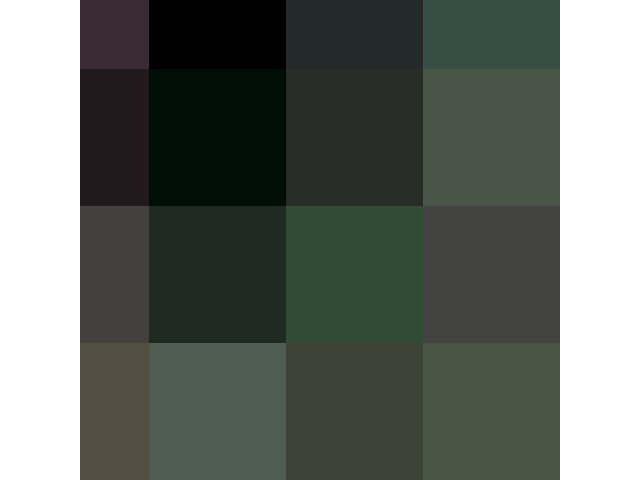

In [20]:
# Apply histogram equalisation
gscript.run_command('g.region', flags='d')
gscript.run_command('i.colors.enhance', blue='lsat7_2002_10', green='lsat7_2002_20', red='lsat7_2002_30')
# Erase any display instance
gscript.run_command('g.region', region='zoom2')
gscript.run_command('d.erase')
# Add the buffer layer to the display
gscript.run_command('d.rgb', blue='lsat7_2002_10', green='lsat7_2002_20', red='lsat7_2002_30')
# Display
Image(filename="map.png")

## Compute NDVI

Now, we will compute [NDVI](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) using [r.mapcal](https://grass.osgeo.org/grass76/manuals/r.mapcalc.html) in its [Python scripting package version](https://grass.osgeo.org/grass76/manuals/libpython/script.html#script.raster.mapcalc).

In [21]:
# Define computational region
gscript.run_command('g.region', flags='d')
# The raster formula to be used
formula = "ndvi=float(lsat7_2002_40hpf-lsat7_2002_30hpf)/float(lsat7_2002_40hpf+lsat7_2002_30hpf)"
# Compute NDVI using
gscript.mapcalc(formula)

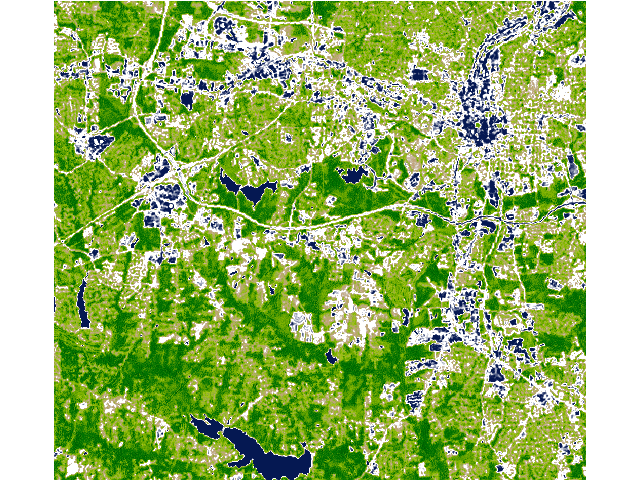

In [22]:
# Define computational region
gscript.run_command('g.region', flags='d')
# Apply colors for NDVI
gscript.run_command('r.colors', map='ndvi', color='ndvi')
# Erase any display instance
gscript.run_command('d.erase')
# Add the buffer layer to the display
gscript.run_command('d.rast', map='ndvi')
# Display
shutil.copy("map.png",os.path.join(outputdir, "NDVI.png"))
Image(filename="map.png")

## Create imagery group

Now, we will create a group of imagery for the segmentation. Two options are demonstrated. 

**OPTION A: write the name of the raster layers as a string**

In [23]:
# Create imagery group - Option A
gscript.run_command('i.group', 
                    group='vnir', 
                    input="lsat7_2002_10hpf,lsat7_2002_20hpf,lsat7_2002_30hpf,lsat7_2002_40hpf"
                   )

0

To print the list of bands in the group, we can use the fonction [read_command](https://grass.osgeo.org/grass76/manuals/libpython/script.html#script.core.read_command) inside a Python print().

In [24]:
# List raster in group
print(gscript.read_command('i.group', group='vnir', flags='l'))

group <vnir> references the following raster maps
-------------
<lsat7_2002_10hpf@user1>    <lsat7_2002_20hpf@user1>    
<lsat7_2002_30hpf@user1>    <lsat7_2002_40hpf@user1>    
-------------



Before showing the  B option, we will remove the imagery group.

In [25]:
gscript.run_command('g.remove', flags='f', type='group', name='vnir')

0

**OPTION B: use the join() fonction of python list to create the content of the input parameter of i.group**

In [26]:
# Create imagery group - Option B
hpf_vnir = gscript.list_strings("rast", pattern="lsat7_2002_??hpf", mapset="user1") # Create a list with the name of the pansharpened raster layers
gscript.run_command('i.group', group='vnir', input=','.join(hpf_vnir[:4])) # Here, only the first 4 bands are added to the group

0

Instead of using read_command, we can use [parse_command](https://grass.osgeo.org/grass76/manuals/libpython/script.html#script.core.parse_command) which return a dictionnary with the output of the Grass command (notice we are using -g flag to force to ouput in shell script style). The dictionnary is transformed into a list with the list() fonction of Python.

In [27]:
# List raster in group
group_list = list(gscript.parse_command('i.group', group='vnir', flags='gl'))
group_list

['lsat7_2002_10hpf@user1',
 'lsat7_2002_20hpf@user1',
 'lsat7_2002_30hpf@user1',
 'lsat7_2002_40hpf@user1']

## Segmentation

Now, we perform segmentation using [i.segment](https://grass.osgeo.org/grass78/manuals/i.segment.html). Then, we compute segment statistics (shape and raster-based statistics) with [i.segment.stats](https://grass.osgeo.org/grass78/manuals/addons/i.segment.stats.html). 

The segmentation parameter have been identified manually with some trial-and-error attempts. More advanced approaches exists, such as using [i.segment.uspo](https://grass.osgeo.org/grass78/manuals/addons/i.segment.uspo.html) or even [SPUSPO](https://www.mdpi.com/2072-4292/10/9/1440).

In [28]:
# Define computational region
gscript.run_command('g.region', flags='d')
# Perform segmentation
gscript.run_command('i.segment', group='vnir', output='segment', threshold='0.05', minsize='10')

0

By reading the raster informations, we knwo how many segment we produced. The number of segment produced correspond to the 'max' value.

In [29]:
segment_info = gscript.raster_info('segment')
print("Our segmentation raster contains %i segments" %segment_info['max'])
segment_info

Our segmentation raster contains 11471 segments


{'north': 228513.0,
 'south': 214989.75,
 'east': 645012.0,
 'west': 629992.5,
 'nsres': 14.25,
 'ewres': 14.25,
 'rows': '949',
 'cols': '1054',
 'cells': '1000246',
 'datatype': 'CELL',
 'ncats': '0',
 'min': 1.0,
 'max': 11471.0,
 'map': 'segment',
 'maptype': 'raster',
 'mapset': 'user1',
 'location': 'nc_spm_08_grass7',
 'database': '/home/demo_user/GRASSDATA',
 'date': '"Mon Feb 21 14:57:22 2022"',
 'creator': '"demo_user"',
 'title': '""',
 'timestamp': '"none"',
 'units': '"none"',
 'vdatum': '"none"',
 'source1': '""',
 'source2': '""',
 'description': '"generated by i.segment"',
 'comments': '"i.segment group="vnir" output="segment" threshold=0.05 radius=1.5 me\\thod="region_growing" similarity="euclidean" minsize=10 memory=300"'}

Now, we will display our segmentation result. Notice that it is a raster format!

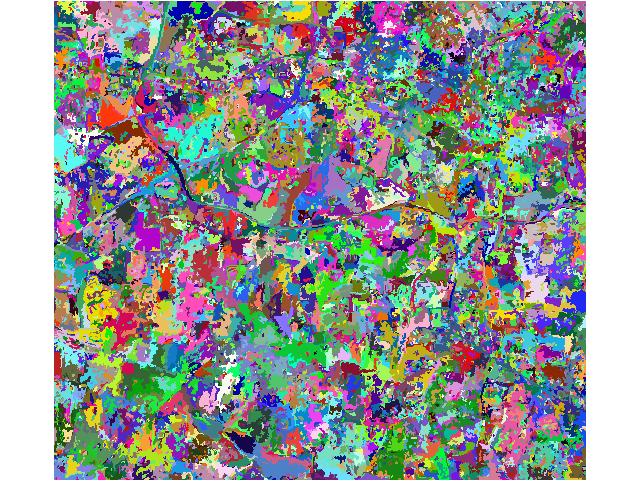

In [30]:
# Define computational region
gscript.run_command('g.region', flags='d')
# Erase any display instance
gscript.run_command('d.erase')
# Add the buffer layer to the display
gscript.run_command('d.rast', map='segment')
# Display
shutil.copy("map.png",os.path.join(outputdir, "Segmentation.png"))
Image(filename="map.png")

For more convenience, we will vectorize the segmentation and display it as overlay of the false-color composite.

In [31]:
# Convert raster into vector
gscript.run_command('r.to.vect', input='segment', output='segment_vect', type='area')

0

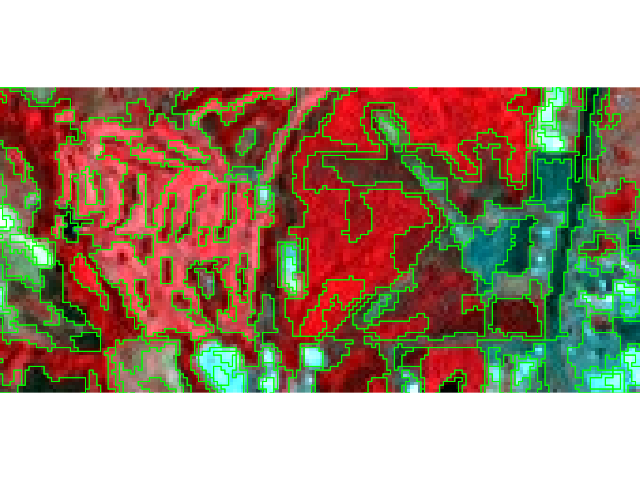

In [32]:
gscript.run_command('g.region', region='zoom1')
gscript.run_command('d.erase')
gscript.run_command('i.colors.enhance', blue='lsat7_2002_20hpf', green='lsat7_2002_30hpf', red='lsat7_2002_40hpf')
gscript.run_command('d.rgb', blue='lsat7_2002_20hpf', green='lsat7_2002_30hpf', red='lsat7_2002_40hpf')
gscript.run_command('d.vect', map='segment_vect', color='0:255:0:255', fill_color='none', width='-1')
Image(filename="map.png")

## Compute segment stats

First, we check if the layers to compute statistics on do not contain null values. If it is the case, we simply replace them by zeros. More advanced approach with interpolation could be considered too.

In [33]:
# Define the list of raster layers to be used for computing segment statistics 
raster_list = list(hpf_vnir) #list() is needed to make hard copy
raster_list.append('ndvi')

In [34]:
# Apply r.null only to raster actually having null values
gscript.run_command('g.region', flags='d')
for x in raster_list:
    univar = gscript.parse_command('r.univar', flags='g', map=x)
    if int(univar['null_cells'])>0:
        print("There are %s null cells in raster '%s'. r.null will be use to fill them with zeros." %(univar['null_cells'],x))
        gscript.run_command('r.null', map=x, null=0)

There are 2950 null cells in raster 'lsat7_2002_10hpf@user1'. r.null will be use to fill them with zeros.
There are 2950 null cells in raster 'lsat7_2002_20hpf@user1'. r.null will be use to fill them with zeros.
There are 2950 null cells in raster 'lsat7_2002_30hpf@user1'. r.null will be use to fill them with zeros.
There are 2950 null cells in raster 'lsat7_2002_40hpf@user1'. r.null will be use to fill them with zeros.
There are 2950 null cells in raster 'ndvi'. r.null will be use to fill them with zeros.


In [35]:
# Compute segment statistics
gscript.run_command('g.region', flags='d')
stat_csv = os.path.join(outputdir,'stats.csv')
rast_stat =  'min,max,stddev,first_quart,median,third_quart,perc_90'
gscript.run_command('i.segment.stats', map='segment', rasters=','.join(raster_list), raster_statistics=rast_stat, csvfile=stat_csv, vectormap='segment_stats', processes='3')

0

We will display the head of the csv file with Pandas

In [36]:
df_stats = pd.read_csv(stat_csv,sep='|')
df_stats.head(6)

,cat,area,perimeter,compact_circle,fd,lsat7_2002_10hpf_min,lsat7_2002_10hpf_max,lsat7_2002_10hpf_stddev,lsat7_2002_10hpf_first_quart,lsat7_2002_10hpf_median,...,lsat7_2002_40hpf_median,lsat7_2002_40hpf_third_quart,lsat7_2002_40hpf_perc_90,ndvi_min,ndvi_max,ndvi_stddev,ndvi_first_quart,ndvi_median,ndvi_third_quart,ndvi_perc_90
0,1,87.0,44.0,1.330724,1.694697,67,85,4.063312,72,74.0,...,117.0,127,136,0.195652,0.560694,0.095644,0.350649,0.438849,0.510000,0.532468
1,2,14.0,20.0,1.507860,2.270243,72,86,3.517449,74,76.0,...,103.0,110,113,0.153846,0.413333,0.067963,0.291925,0.350245,0.381579,0.401274
2,3,29.0,30.0,1.571511,2.020115,66,86,5.281831,70,73.0,...,109.0,112,116,0.222222,0.536232,0.095295,0.303371,0.423077,0.496599,0.522581
3,4,113.0,96.0,2.547576,1.931020,64,84,3.675604,71,73.0,...,101.0,108,113,0.119403,0.530435,0.080779,0.341615,0.393103,0.453416,0.496296
4,5,12.0,16.0,1.302940,2.231469,72,82,2.861381,73,74.0,...,119.0,125,128,0.333333,0.508772,0.058769,0.370787,0.403976,0.471698,0.497076
5,6,15.0,28.0,2.039424,2.460902,62,79,4.014418,69,70.0,...,136.0,139,142,0.431579,0.638710,0.045771,0.502703,0.544910,0.554286,0.564246


And the name of all columns

In [37]:
print("\n".join(df_stats.columns.tolist()))

cat
area
perimeter
compact_circle
fd
lsat7_2002_10hpf_min
lsat7_2002_10hpf_max
lsat7_2002_10hpf_stddev
lsat7_2002_10hpf_first_quart
lsat7_2002_10hpf_median
lsat7_2002_10hpf_third_quart
lsat7_2002_10hpf_perc_90
lsat7_2002_20hpf_min
lsat7_2002_20hpf_max
lsat7_2002_20hpf_stddev
lsat7_2002_20hpf_first_quart
lsat7_2002_20hpf_median
lsat7_2002_20hpf_third_quart
lsat7_2002_20hpf_perc_90
lsat7_2002_30hpf_min
lsat7_2002_30hpf_max
lsat7_2002_30hpf_stddev
lsat7_2002_30hpf_first_quart
lsat7_2002_30hpf_median
lsat7_2002_30hpf_third_quart
lsat7_2002_30hpf_perc_90
lsat7_2002_40hpf_min
lsat7_2002_40hpf_max
lsat7_2002_40hpf_stddev
lsat7_2002_40hpf_first_quart
lsat7_2002_40hpf_median
lsat7_2002_40hpf_third_quart
lsat7_2002_40hpf_perc_90
ndvi_min
ndvi_max
ndvi_stddev
ndvi_first_quart
ndvi_median
ndvi_third_quart
ndvi_perc_90


## Import training labels and link them with segment stats

In [39]:
# Import vector layer with training points
gscript.run_command('v.import', input='/home/demo_user/Workshop/Qgis_training_sample/Training_NC.gpkg', layer='Training_NC', output='Training_NC')
# Save the segment ID corresponding to each training point 
gscript.run_command('v.what.rast', map='Training_NC', raster='segment', column='segment_id')
# Export the attribute table to a csv file and display it
label_csv = os.path.join(outputdir,'training_labels.csv')
gscript.run_command('db.out.ogr', input='Training_NC', output=label_csv, format='CSV')
df_labels = pd.read_csv(label_csv)
df_labels.head(7)

,cat,label,segment_id
0,1,3,1504
1,2,22,10
2,3,22,4596
3,4,22,627
4,5,22,8107
5,6,22,8035
6,7,22,9039


In [40]:
# Join the training and the labels
df_training = pd.merge(df_stats, df_labels, how="inner",left_on='cat',right_on='segment_id')
df_training.drop(columns=['cat_x','cat_y','segment_id'], inplace=True)
df_training.head(7)

,area,perimeter,compact_circle,fd,lsat7_2002_10hpf_min,lsat7_2002_10hpf_max,lsat7_2002_10hpf_stddev,lsat7_2002_10hpf_first_quart,lsat7_2002_10hpf_median,lsat7_2002_10hpf_third_quart,...,lsat7_2002_40hpf_third_quart,lsat7_2002_40hpf_perc_90,ndvi_min,ndvi_max,ndvi_stddev,ndvi_first_quart,ndvi_median,ndvi_third_quart,ndvi_perc_90,label
0,780.0,426.0,4.302861,1.818342,72,108,4.304309,83,86.0,88,...,105,110,-0.106599,0.311688,0.071439,0.062857,0.122608,0.160221,0.195652,22
1,396.0,132.0,1.871205,1.632657,61,80,2.965686,69,71.0,72,...,113,121,0.309859,0.629032,0.055919,0.430769,0.469983,0.507463,0.539474,21
2,10.0,14.0,1.248887,2.292157,164,254,29.192636,182,195.0,236,...,183,186,-0.303226,-0.151242,0.056571,-0.284281,-0.266173,-0.164384,-0.156463,1
3,357.0,118.0,1.761745,1.623306,82,109,4.405089,89,91.0,95,...,116,121,-0.012987,0.278351,0.050774,0.070000,0.100000,0.135678,0.172775,22
4,21.0,30.0,1.846744,2.234271,153,176,5.727762,159,164.0,167,...,106,107,-0.351724,-0.272727,0.019128,-0.328767,-0.310127,-0.302326,-0.294964,1
5,77.0,70.0,2.250338,1.956111,108,149,9.720985,119,128.0,134,...,111,117,-0.340278,-0.120000,0.056974,-0.304348,-0.261745,-0.212996,-0.181159,3
6,111.0,54.0,1.445864,1.694002,64,82,3.451991,72,74.0,76,...,31,41,-0.622642,0.290323,0.201972,-0.423077,-0.281250,-0.093333,0.042253,4


In [41]:
# Export csv with trainint stats
training_csv = os.path.join(outputdir,'training.csv')
df_training.to_csv(training_csv,sep='|')

## Classification

Now, we will perform the classification using [v.class.mlR](https://grass.osgeo.org/grass78/manuals/addons/v.class.mlR.html). 
This add-on will launch a R script in the background. The first time you run it, it needs to install several R packages, so it can take a while (about X minutes).

In [42]:
# Classification using v.class.mlR
gscript.run_command('v.class.mlR',
                    segments_file=stat_csv,
                    training_file=training_csv,
                    raster_segments_map='segment',
                    classified_map='classif',
                    train_class_column='label',
                    output_class_column='vote',
                    output_prob_column='prob',
                    classifiers='svmRadial,svmLinear,rf,rpart,C5.0,knn',
                    folds='5', partitions='10', tunelength='10',
                    weighting_modes='smv,swv',
                    weighting_metric='accuracy',
                    r_script_file=os.path.join(outputdir,'vclassmlr.R'),
                    variable_importance_file=os.path.join(outputdir,'var_importance'),
                    processes='7',
                    flags='i')

0

In [43]:
# List classification maps 
classif_maps = gscript.list_strings('rast', pattern='classif', flag='r')
classif_maps

['classif_C5.0@user1',
 'classif_knn@user1',
 'classif_rf@user1',
 'classif_rpart@user1',
 'classif_smv@user1',
 'classif_svmLinear@user1',
 'classif_svmRadial@user1',
 'classif_swv@user1']

In [44]:
# Create color rules files for r.colors
color_file = os.path.join(outputdir,'colors.txt')
with open(color_file, 'w') as f:
    f.write('1  255:0:0\n')  #Urban  
    f.write('3  255:229:204\n') #Bare soil
    f.write('4  0:0:205\n') #Water
    f.write('21  51:102:0\n') #High vegetation
    f.write('22 178:255:102\n') #Low vegetation

In [45]:
# Apply color rule to the classification maps
for maps in classif_maps:
    gscript.run_command('r.colors', map=maps, rules=color_file)

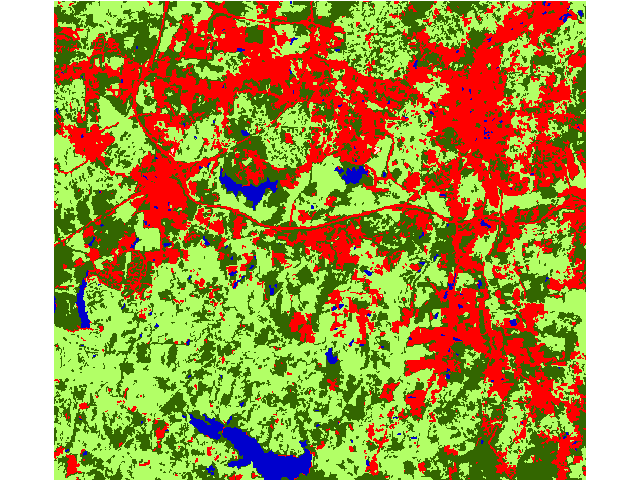

In [48]:
# Display SVM Linear (Support Vector Machine)
gscript.run_command('g.region', flags='d')
gscript.run_command('d.erase')
gscript.run_command('d.rast', map='classif_svmLinear')
shutil.copy("map.png",os.path.join(outputdir, "classif_svmLinear.png"))
Image(filename="map.png")

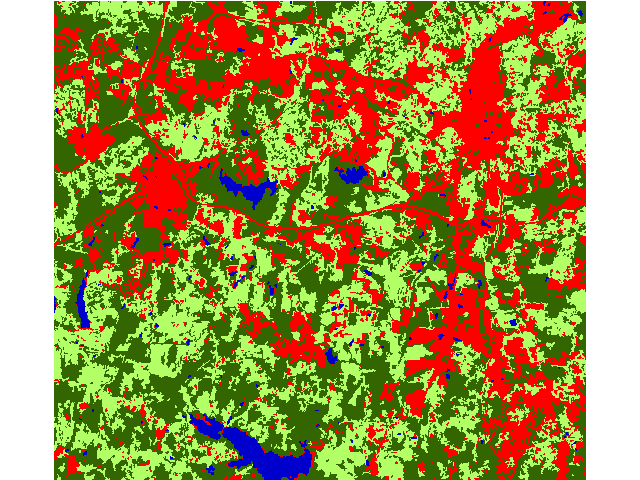

In [46]:
# Display SVM Radial (Support Vector Machine)
gscript.run_command('g.region', flags='d')
gscript.run_command('d.erase')
gscript.run_command('d.rast', map='classif_svmRadial')
shutil.copy("map.png",os.path.join(outputdir, "classif_svmRadial.png"))
Image(filename="map.png")

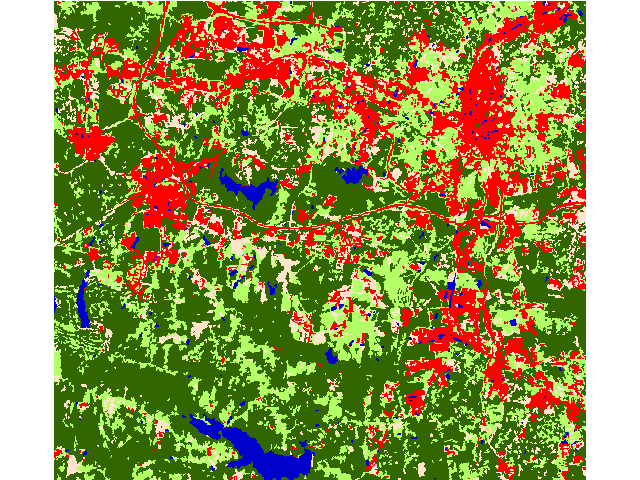

In [49]:
# Display RF (Random Forest)
gscript.run_command('g.region', flags='d')
gscript.run_command('d.erase')
gscript.run_command('d.rast', map='classif_rf')
shutil.copy("map.png",os.path.join(outputdir, "classif_rf.png"))
Image(filename="map.png")

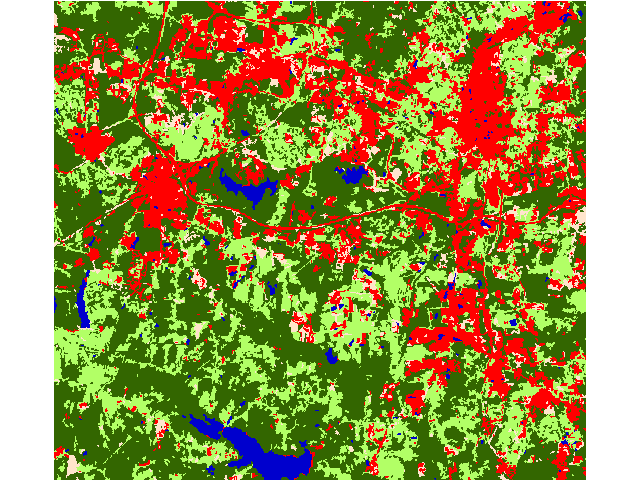

In [50]:
# Display SMV (Simple Majority Vote)
gscript.run_command('g.region', flags='d')
gscript.run_command('d.erase')
gscript.run_command('d.rast', map='classif_smv')
shutil.copy("map.png",os.path.join(outputdir, "classif_smv.png"))
Image(filename="map.png")

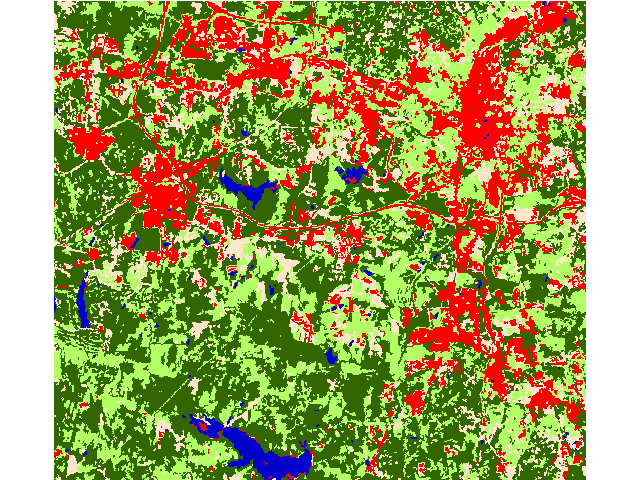

In [53]:
# Display C5.0 (Simple Majority Vote)
gscript.run_command('g.region', flags='d')
gscript.run_command('d.erase')
gscript.run_command('d.rast', map='classif_C5.0')
shutil.copy("map.png",os.path.join(outputdir, "classif_C50.png"))
Image(filename="map.png")

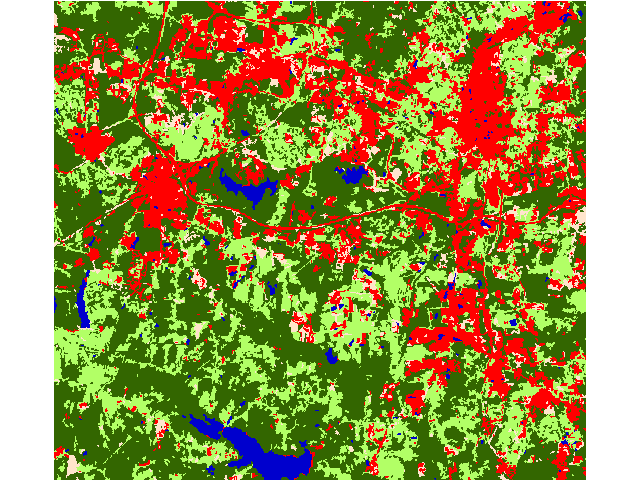

In [51]:
# Display SMV (Simple Majority Vote)
gscript.run_command('g.region', flags='d')
gscript.run_command('d.erase')
gscript.run_command('d.rast', map='classif_smv')
shutil.copy("map.png",os.path.join(outputdir, "classif_smv.png"))
Image(filename="map.png")

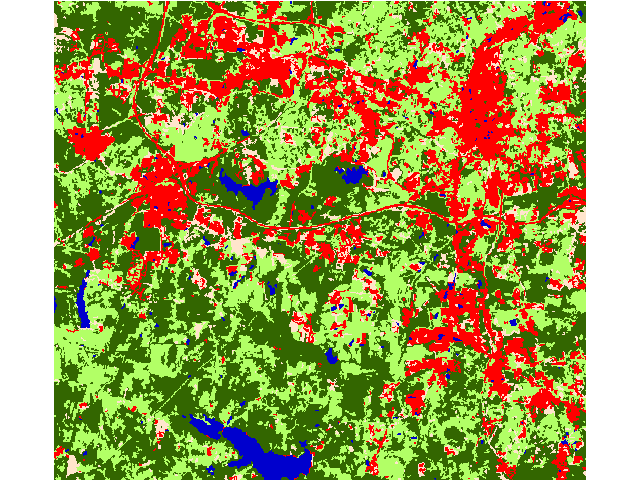

In [52]:
# Display SMV (Simple Weighted Vote)
gscript.run_command('g.region', flags='d')
gscript.run_command('d.erase')
gscript.run_command('d.rast', map='classif_swv')
shutil.copy("map.png",os.path.join(outputdir, "classif_swv.png"))
Image(filename="map.png")

More advance classification procedure with R can be perform with %%R magic cells. For an example check [HERE](https://github.com/tgrippa/Semi_automated_OBIA_processing_with_local_USPO/blob/f6b04492e443fcf02a3a071ad563110a740ad0da/Classification/Classification.ipynb).